#TODO for this Chapter

1. Read the Encoder-Decoder chapter again to understand the idea. It's a foundation for Transformer
2. It's confusing with all the mask operations and stuff. Be patient and come back later to fully understand the concept
3. Chapt 11.4, Badhanua Attention Mechanism is important. *Read again*
4. Take it slow, there are so many hard and new concepts 
5. learn more about matrix operations like pertmute dimention, einsum, ...

*NOTE: this section is every important to understand fully. It's the foundation of GPT3 so take time to gasp the ideas that form Transformer*

Concept to know:
Attention pooling by similarity:
- Attention Pooling via Nadaraya-Watson Regression
Attention scoring functions:
- 

In [ ]:
# Setup env
!pip install setuptools==66
!pip install matplotlib_inline
!pip install d2l==1.0.0b0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from d2l import torch as d2l
import math
from torch import nn
import numpy as np
from torch.nn import functional as F
import pandas as pd

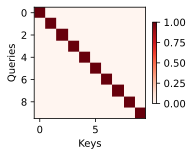

In [ ]:
#visualize a weight matrix 
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
d2l.show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Pooling explaination
https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-pooling.htm

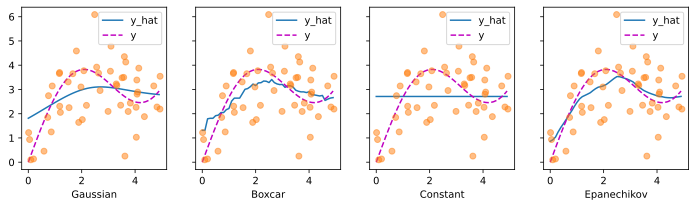

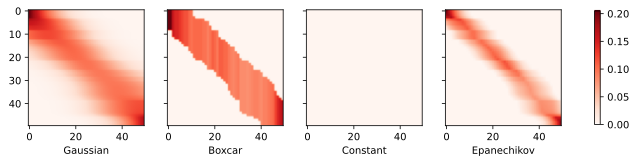

In [ ]:
#define kernels:
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))
    
def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))



#Plot the kernels
# fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
# for kernel, name, ax in zip(kernels, names, axes):
#     ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
#     ax.set_xlabel(name)

#Produce dummy data using sin(x)
# y = 2 * sin(x) + x + e ( e is random noise ) 
def f(x):
  return 2 * torch.sin(x) + x

n = 50
x_train,_ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

# masked softmax esentially turn off the weights of each sample using valid_lens
https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html#masked-softmax-operation


In [ ]:
def masked_softmax(X, valid_lens, debug = False):
  def _sequence_mask(X, valid_len, value = 0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,device = X.device)[None, :] < valid_len[:, None]
    if debug:
      print('valid_len = ', valid_len)
      print('valid_len shape ', valid_len.shape)
      print(mask)
    X[~mask] = value
    return X
  
  if debug:
    print('X = ', X)
    print('valid len = ', valid_lens)
  
  if valid_lens == None:
    return nn.functional.softmax(X, dim = -1)
  
  else:
    shape = X.shape
    if debug: 
      print('x shape = ', X.shape)
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
      if debug:
        print('dim = 1, ', valid_lens)
    else:
      valid_lens = valid_lens.reshape(-1)
      if debug:
        print('dim != 1, ', valid_lens)

    # this line combine the batches
    # X.reshape(-1, shape[-1])
    # like (2,2,4) becomes (4,4). Think like the matricies are stacked up into 1 big matrix
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value = -1e6)
    if debug:
      print(X)

    return nn.functional.softmax(X.reshape(shape), dim=-1)

X = torch.rand(2, 2, 4)
valid_lens = torch.tensor([2, 3])
softmax = masked_softmax(X, valid_lens, True)

X =  tensor([[[0.7424, 0.2993, 0.3089, 0.7758],
         [0.7351, 0.0570, 0.2493, 0.7469]],

        [[0.4730, 0.2097, 0.8335, 0.8758],
         [0.0531, 0.4559, 0.6723, 0.6712]]])
valid len =  tensor([2, 3])
x shape =  torch.Size([2, 2, 4])
dim = 1,  tensor([2, 2, 3, 3])
valid_len =  tensor([2, 2, 3, 3])
valid_len shape  torch.Size([4])
tensor([[ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False]])
tensor([[ 7.4242e-01,  2.9934e-01, -1.0000e+06, -1.0000e+06],
        [ 7.3509e-01,  5.7016e-02, -1.0000e+06, -1.0000e+06],
        [ 4.7301e-01,  2.0970e-01,  8.3346e-01, -1.0000e+06],
        [ 5.3079e-02,  4.5592e-01,  6.7229e-01, -1.0000e+06]])


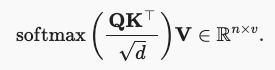

In [ ]:

class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
  
  # I added debug to print more details
  def forward(self, queries, keys, values, valid_lens = None, debug = False):
    #sample shape
    # n is number of queries
    # m is number of key-value pairs
    # d is length of queries and keys 
    # v is length of value 
    # queries shape (batch_size, n, d)
    # keys shape ( batch_size, m, d)
    # value shape (batch_size, m, v)
    # valid_lens shape (batch_size, ) or (batch_size, n)
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
    if debug:
      print('queries shape =' ,queries.shape)
      print('keys shape = ',keys.shape)
      print('values shape = ', values.shape)
      print('scores shape =',scores.shape)
      print('valid_lens shape =',valid_lens.shape)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

#Test run 
#
batch_size = 2
n = 1
m = 10
d = 2
v = 4
queries = torch.normal(0,1,(batch_size, n, d))
keys = torch.normal(0,1,(batch_size, m, d))
values = torch.normal(0,1,(batch_size, m, v ))
# values in valid_lens must not > than m
valid_lens = torch.tensor([2,6])

attention = DotProductAttention(dropout = 0.5)
# set to eval mode, Dropout and BatchNorm behaves differently
attention.eval()
attention_weights = attention(queries, keys, values, valid_lens, True)
# print('attention weights = ', attention_weights.shape)
output = attention_weights,(2,1,4)

# print('output shape = ', output.shape)



queries shape = torch.Size([2, 1, 2])
keys shape =  torch.Size([2, 10, 2])
values shape =  torch.Size([2, 10, 4])
scores shape = torch.Size([2, 1, 10])
valid_lens shape = torch.Size([2])


torch.Size([2, 1, 10])


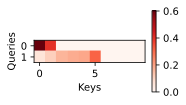

In [ ]:
#show heat map
print(attention.attention_weights.shape)
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)), xlabel='Keys', ylabel = 'Queries')

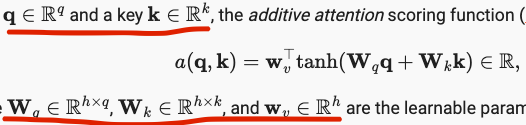

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 1, 4])


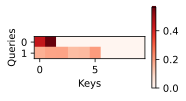

In [ ]:
# when queries and keys have different dimensionality
# https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html#additive-attention
class AdditiveAttention(nn.Module):
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.LazyLinear(num_hiddens, bias = False)
    self.W_q = nn.LazyLinear(num_hiddens, bias = False)
    self.W_v = nn.LazyLinear(1, bias= False)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, queries, keys, values, valid_lens, debug = False):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.W_v(features).squeeze(-1)

    self.attention_weights = masked_softmax(scores, valid_lens)
    if debug:
      print('queries shape=', queries.shape)
      print('keys shape=', keys.shape)
      print('queries shape unsqueeze=', queries.unsqueeze(2).shape)
      print('keys shape unsqueeze=', keys.unsqueeze(1).shape)
      print('values shape=', values.shape)
      print('valid_lens shape=', valid_lens.shape)
      print('features shape = ', features.shape)
      print('scores shape = ', scores.shape)
      print('attention weight shape = ', self.attention_weights.shape)
    
    return torch.bmm(self.dropout(self.attention_weights), values)
  
#Test run the class
# queries = torch.normal(0,1,(2,1,20))
# attention = AdditiveAttention(num_hiddens = 8, dropout = 0.1)
# attention.eval()
# a = attention(queries, keys, values, valid_lens, True)
# print(a)
# print(a.shape)

# #show heat map of scores
# d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),

queries = torch.normal(0,1,(2,1,20))
keys = torch.normal(0,1,(2,10,2))
values = torch.normal(0,1,(2,10,4))

valid_lens = torch.tensor([2,6])

attention = AdditiveAttention(num_hiddens = 8, dropout = 0.1)
attention.eval()
attention_weight = attention(queries, keys, values, valid_lens) 
print(attention_weight.shape)

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

# The Bahdanau Attention Mechanism
https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html#the-bahdanau-attention-mechanism




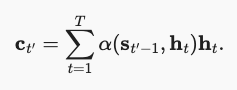

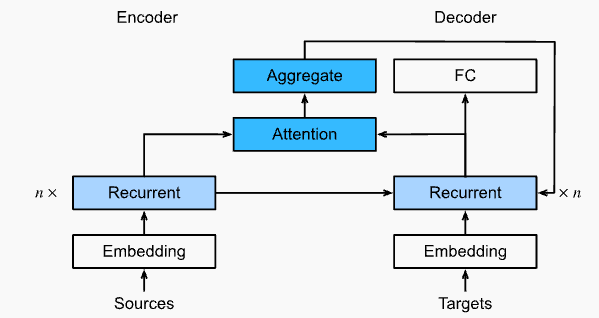

In [ ]:
#interface
class AttentionDecoder(d2l.Decoder):
  def __init__(self):
    super().__init__()
  
  @property
  def attention_weights(self):
    raise NotImplementedError

class Seq2SeqAttentionDecoder(AttentionDecoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0):
    super().__init__()

    #calculate attention weights using keys, values, queries
    self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout = dropout)
    #Lazy Linear will infer input features without specifying beforehand
    self.dense = nn.LazyLinear(vocab_size)
    #init the weights of GRU and LazyLinear layer
    self.apply(d2l.init_seq2seq)

  def init_state(self, enc_outputs, enc_valid_lens):
    #output shape (num_steps, batch_size, num_hiddens)
    #hiden state: (num_layers, batch_size, num_hddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1,0,2), hidden_state, enc_valid_lens) 

  def forward(self, X, state):
    #enc outputs shape: (batch_size, num_steps, num_hiddens)
    #hidden state: (num_layers, batch_size, num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    #X shape: (num_steps, batch_size, embed_size)
    X = self.embedding(X).permute(1,0,2)
    outputs, self._attention_weights = [], []

    for x in X:
      query = torch.unsqueeze(hidden_state[-1], dim = 1)
      context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      # concat feature dimension 
      x = torch.cat((context, torch.unsqueeze(x, dim = 1)), dim = -1)
      out, hidden_state = self.rnn(x.permute(1,0,2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)

    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1,0,2), [enc_outputs, hidden_state, enc_valid_lens]
  
  @property
  def attention_weights(self):
      return self._attention_weights


In [ ]:
#@title Default title text
vocab_size = 10 #@param {type:"number"}
embed_size = 8 #@param {type:"number"}
num_hiddens = 16 #@param {type:"number"}
num_layers = 2 #@param {type:"number"}
batch_size = 4 #@param {type:"number"}
num_steps = 7 #@param {type:"number"}

#define encoder and decoder
encoder =  d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)

X = torch.zeros((batch_size, num_steps),\
                dtype=torch.long)

enc_output, state = encoder(X)
# enc output shape = (num_steps, batch_size, num_hiddens)
print('encoder output shape = ', enc_output.shape)
# state shape = (num_layers, batch_size, num_hiddens)
print('state shape = ', state.shape)
state = decoder.init_state(encoder(X), None)

output, state = decoder(X, state)

# decoder output shape = (batch_size, num_steps, vocab_size)
print('output shape = ', output.shape)
# encoder output shape = (batch_size, num_steps, num_hiddnes)
print('encoder output shape =', state[0].shape)
# hidden state shape = (batch_size, num_hiddens) 
print('hidden state shape = ',state[1][0].shape)

d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

#For training code. Goes here
#https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html#training

encoder output shape =  torch.Size([7, 4, 16])
state shape =  torch.Size([2, 4, 16])
output shape =  torch.Size([4, 7, 10])
encoder output shape = torch.Size([4, 7, 16])
hidden state shape =  torch.Size([4, 16])


go . => ['gras', 'il', 'chaud', 'perdu', 'aucune', 'aucune', 'tu', 'tu', 'ma'], bleu,0.000
i lost . => ['gras', 'sérieux', 'sérieux', 'ferme-la', 'ferme-la', 'ferme-la', 'gagné', 'gagné', 'gagné'], bleu,0.000
he's calm . => ['gras', 'sois', 'chaud', 'confiance', 'pas', 'nous', 'confiance', 'confiance', 'aucune'], bleu,0.000
i'm home . => ['gras', 'chaud', 'suis-je', 'aucune', 'aucune', 'boulot', 'aucune', 'aucune', 'tom'], bleu,0.000


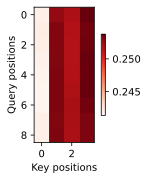

In [ ]:
#Train this encoder-decoder with attention

#Load Data
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)

# trainer.fit(model, data)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

#show attention weights
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

# Multi-Head attention chapt 11.5
https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html


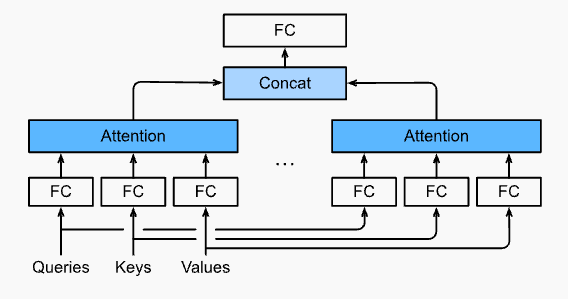

In [ ]:
class MultiHeadAttention(d2l.Module):
  def __init__(self, num_hiddens, num_heads, dropout, bias = False, debug = False, **kwargs):
    super().__init__()
    self.num_heads = num_heads
    self.attention = d2l.DotProductAttention(dropout)
    self.W_q = nn.LazyLinear(num_hiddens, bias = bias)
    self.W_k = nn.LazyLinear(num_hiddens, bias = bias)
    self.W_v = nn.LazyLinear(num_hiddens, bias = bias)
    self.W_o = nn.LazyLinear(num_hiddens, bias = bias)
    self.debug = debug
      
  def transpose_qkv(self, X):
    # X shape: (batch_size, # of queries or key/value pairs, num_hiddens)
    # output shape: (batch_size, # of queries or key/value pairs, num_heads, num_hiddens / num_heads)
    #-1 = num_hiddens / num_heads
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    if self.debug:
      print('transpose_qkv output')
      print('X shape after reshape = ', X.shape)
    #permute shape into (batch_size, num_heads, # of key/value pair, num_hiddens//num_heads)
    X = X.permute(0,2,1,3)

    #output shape = (batch_size * num_heads, # of kv_pair, num_hiddens//heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

  def transpose_output(self, X):
    #this reverse operation in transpose_qkv
    #input shape = (batch_size * num_heads, # of kv_pair, num_hiddens//heads)
    #reshape to (batch_size, num_heads, # of kv_pair, num_hiddens//heads)
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    #permute back to (batch_size, # of kv pair, num_heads, num_hiddens// num_heads)
    X = X.permute(0,2,1,3)
    # reshape back to : (batch_size, # of queries or key/value pairs, num_hiddens)
    return X

  def forward(self, queries, keys, values, valid_lens):
    # queries shape = (batch_size, num of queries, num_hiddens)
    # valid_lens = (batch-sie, ) or (batch_size, num_queries)
    # after transpose qkv
    # queries, keys, values shape ( batch_size * num_heads,# of queries or key/value pairs, num_hiddens / num_heads)
    out_q = self.W_q(queries)
    out_k = self.W_k(keys)
    out_v = self.W_v(values)

    queries = self.transpose_qkv(out_q)
    keys = self.transpose_qkv(out_k)
    values = self.transpose_qkv(out_v)

    if valid_lens is not None:
      valid_lens = torch.repeat_interleave(valid_lens, repeats = self.num_heads, dim = 0)

    #output shape ( batch_size * num_heads, # of queries or kv_pair, num_hiddens//num_heads)
    output = self.attention(queries, keys, values, valid_lens)

    # reshape back to : (batch_size, # of queries or key/value pairs, num_hiddens)
    output_concat = self.transpose_output(output)
    if self.debug:
      print('out q shape = ', out_q.shape)
      print('transpose q shape = ', queries.shape)
      print('out k shape = ', out_k.shape)
      print('transpose key shape = ', keys.shape)
      print('out v shape = ', out_v.shape)
      print('transpose value shape = ', values.shape)
      print('attention output shape = ', output.shape)
      print('output after concat = ', output_concat.shape)
      print('final output = ', (self.W_o(output_concat)).shape)
    return self.W_o(output_concat)
    

#Test run
num_hiddens, num_heads = 100,  5
batch_size, num_queries, num_kv_pairs = 2,4,6
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5, debug = True)
valid_lens = torch.tensor([3,2])

X = torch.ones((batch_size, num_queries, num_hiddens))
print('shape of X =', X.shape)
Y = torch.ones((batch_size, num_kv_pairs, num_hiddens))
print('shape of Y =', Y.shape)

output = attention(X, Y, Y, valid_lens)

print('output shape = ', output.shape)

shape of X = torch.Size([2, 4, 100])
shape of Y = torch.Size([2, 6, 100])
output shape =  torch.Size([2, 4, 100])


# Self-attention
https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html

1. self-attention ditches sequential operations in favor of parallel computation  --> it doesn't preserve order
2. positional encodings preserver order to feed to model
3. positional encodings can be learned or fixed

Machine Learning Mastery article about positional encoding: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
- Positional encoding is the scheme through which the knowledge of the order of objects in a sequence is maintained.


In [ ]:
num_heads, num_hiddens = 5, 100
batch_size, num_queries, valid_lens = 2,4, torch.tensor([3,2])

X = torch.ones((batch_size, num_queries, num_hiddens))

attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)

attention_out = attention(X, X, X, valid_lens)

#attention output shape = (batch_size, num_queries, num_hiddens)
print(attention_out.shape)


torch.Size([2, 4, 100])


# Fixed positional encoding with sine and cosine

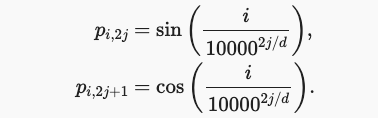

shape X =  torch.Size([1, 60, 32])
shape X after positional encoding =  torch.Size([1, 60, 32])


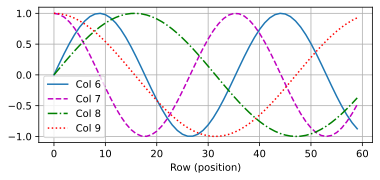

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, num_hiddens, dropout, max_len = 10000):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.P = torch.zeros((1, max_len, num_hiddens))
    #this is just a way calculate that formula without using loop
    X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
    self.P[:, :, 0::2] = torch.sin(X)
    self.P[:, :, 1::2] = torch.cos(X)

  def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device)
    return self.dropout(X)

#Test run
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = torch.zeros((1, num_steps, encoding_dim))
print("shape X = ", X.shape)
X = pos_encoding(X)
print("shape X after positional encoding = ", X.shape)
P = pos_encoding.P[:, :X.shape[1],:]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)', figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])


# Transformer Architecture
https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html

Notes: 
- the Transformer model is solely based on attention mechanisms without any convolutional or recurrent layer




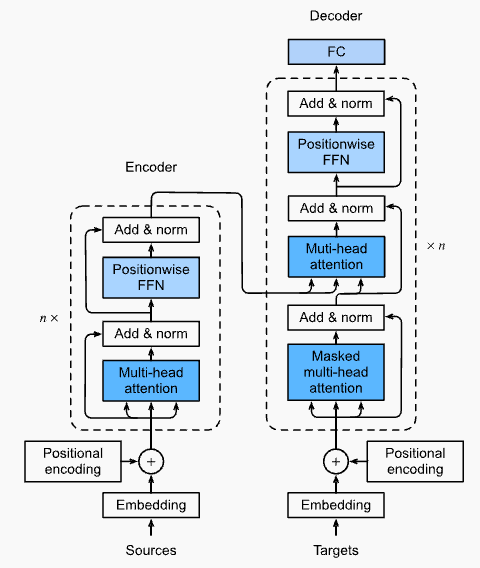

In [ ]:
class PositionWiseFFN(nn.Module):
  def __init__(self, num_hiddens, num_outputs):
    super().__init__()
    self.dense1 = nn.LazyLinear(num_hiddens)
    self.relu = nn.ReLU()
    self.dense2 = nn.LazyLinear(num_outputs)

  def forward(self, X):
    return self.dense2(self.relu(self.dense1(X)))

#Notes:
# LayerNorm is more effective to NLP tasks than BatchNorm do in computer vision tasks
class AddNorm(nn.Module):
  def __init__(self, norm_shape, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(norm_shape)
  
  def forward(self, X, Y):
    return self.ln(self.dropout(Y) + X)

#Test run AddNorm
X = torch.ones(2,3,4)
Y = torch.ones(2,3,4)

add_norm = AddNorm(4, 0.5)
added_and_normed = add_norm(X,Y)

print(added_and_normed)

print(added_and_normed.shape)

tensor([[[-0.5773, -0.5773, -0.5773,  1.7320],
         [ 0.5773, -1.7320,  0.5773,  0.5773],
         [-0.5773,  1.7320, -0.5773, -0.5773]],

        [[-0.5773, -0.5773, -0.5773,  1.7320],
         [-1.0000, -1.0000,  1.0000,  1.0000],
         [-1.0000,  1.0000,  1.0000, -1.0000]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([2, 3, 4])


In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, num_hiddens,ffn_num_hiddens, num_heads, dropout, bias = False):
    super().__init__()
    self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, bias)
    # num_hiddens = num_hiddens, num_heads = num_heads, dropout = dropout
    self.addnorm1 = AddNorm(num_hiddens, dropout)
    self.addnorm2 = AddNorm(num_hiddens, dropout)
    self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
  
  def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
    return self.addnorm2(Y, self.ffn(Y))
  
#test run
print('Test run for transformer encoder block')
print("X input shape: (batch_size, # q, # hidden)")
X = torch.ones((2,100,24))
valid_lens = torch.tensor([3,2])
encoder_block = TransformerEncoderBlock(24,48,8,0.5)
encoder_block.eval()

output = encoder_block(X, valid_lens)

#output shape doesn't change
print('output shape = ', output.shape)

class TransformerEncoder(d2l.Encoder):
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout, bias = False, debug = False):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
    self.blocks = nn.Sequential()
    self.debug = debug
    for i in range(num_blocks):
      self.blocks.add_module(f'encoder block {i}', \
      TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, bias))

  def forward(self, X, valid_lens):
    # X shape = ( batch_size, num_hiddens)
    # embeddding values are * with sqrt(num_hiddens) to rescale before sum up
    # embedding layer will transform X from (batch_size, # q) --> (batch_size, # q, # hiddens)
    X = self.embedding(X) * math.sqrt(self.num_hiddens)
    X = self.pos_encoding(X)
    self.attention_weights = [None] * len(self.blocks)

    for i, block in enumerate(self.blocks):
      X = block(X, valid_lens)
      #block.MultiHeadAttention.DotProductAttention.attention_weights 
      self.attention_weights[i] = block.attention.attention.attention_weights
    #output shape = (batch_size, # of queries, num_hiddens)
    return X

#Test run
print()
print('Test run for TransformerEncoder complete')
vocab_size = 200
num_hiddens = 24
ffn_num_hiddens = 48
num_heads = 8
num_blocks = 2 
dropout = 0.5
bias = False
debug = True 

encoder = TransformerEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout, bias, debug)
#input shape = (batch_size, # q)
X = torch.ones((2,100), dtype = torch.long)
print("X shape = ", X.shape)
Y = encoder(X, torch.tensor([3,2]))
print('output shape = ', Y.shape)


Test run for transformer encoder block
X input shape: (batch_size, # q, # hidden)
output shape =  torch.Size([2, 100, 24])

Test run for TransformerEncoder complete
X shape =  torch.Size([2, 100])
output shape =  torch.Size([2, 100, 24])


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#DecoderBlock
#https://www.youtube.com/watch?v=exOBYU3TnsA&t=29s

class TransformerDecoderBlock(nn.Module):
  #ith block in the Transformer decoder
  def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i, debug = False):
    super().__init__()
    self.i = i
    self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
    self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)

    self.addnorm1 = AddNorm(num_hiddens, dropout)
    self.addnorm2 = AddNorm(num_hiddens, dropout)
    self.addnorm3 = AddNorm(num_hiddens, dropout)

    self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)

    self.debug = debug

  def forward(self, X, state):
    enc_outputs, enc_valid_lens = state[0], state[1]
    # state[2][i] is representation of decoded ouptut at ith block
    # up to the current time step
    if state[2][self.i] is None:
      key_values = X
    else:
      key_values = torch.cat((state[2][self.i], X), dim = 1)
    
    state[2][self.i] = key_values

    if self.training:
      batch_size, num_steps, _ = X.shape
      # decoder valid lens shape = (batch_size, num_steps)
      # row is [1,2,..., num_steps]
      # during training, only make tokens before this time step visible
      dec_valid_lens = torch.arange(1, num_steps + 1, device = X.device).repeat(batch_size, 1)
    else:
      dec_valid_lens = None
    
    X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
    Y = self.addnorm1(X, X2)
    #Encoder-decoder attention, shape of enc_outputs
    #(batch_size, # q num_hiddens)
    # Y shape is (batch_size, # kv_pairs, # hiddens) so the output of attention
    # block is the same with Y
    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
    Z = self.addnorm2(Y, Y2)

    if self.debug:

      print("encoder output shape = ", enc_outputs.shape)
      print("X2 shape = ", X2.shape)
      print("Y shape = ", Y.shape)
      print("Y2 shape = ", Y2.shape)
      print("Z shape = ", Z.shape)

    return self.addnorm3(Z, self.ffn(Z)), state

#Test run
# this is the output shape from encoder block
#this pretend to be the final output for encoder layers
X = torch.ones((2,100,24))
# this valid_lens is generated during dataset building
valid_lens = torch.tensor([3,2])

encoder_block = TransformerEncoderBlock(24,48,8,0.5)
encoder_block.eval()
enc_output = encoder_block(X, valid_lens)

#configure decoder block
num_hiddens = 24
ffn_num_hiddens = 48
num_heads = 8
dropout = 0.5
debug = True

decoder_block = TransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, 0, debug)

X = torch.ones((2,200,24))

state = [enc_output, valid_lens, [None]]
decoder_output, state = decoder_block(X, state)

print('decoder output shape = ', decoder_output.shape)

encoder output shape =  torch.Size([2, 100, 24])
X2 shape =  torch.Size([2, 200, 24])
Y shape =  torch.Size([2, 200, 24])
Y2 shape =  torch.Size([2, 200, 24])
Z shape =  torch.Size([2, 200, 24])
decoder output shape =  torch.Size([2, 200, 24])


In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.num_blocks = num_blocks
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
    self.blocks = nn.Sequential()

    self.dense = nn.LazyLinear(vocab_size)

    for i in range(num_blocks):
      self.blocks.add_module(f'block {i}', TransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, i))

  def init_state(self, enc_outputs, enc_valid_lens):
    return [enc_outputs, enc_valid_lens, [None] * self.num_blocks]
  
  def forward(self, X, state):
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    self._attention_weights = [[None] * len(self.blocks) for _ in range(2)]

    for i, block in enumerate(self.blocks):
      X, state = block(X, state)
      self._attention_weights[0][i] = block.attention1.attention.attention_weights
      self._attention_weights[1][i] = block.attention2.attention.attention_weights 
    
    return self.dense(X), state
  
  @property
  def attention_weights(self):
    return self._attention_weights


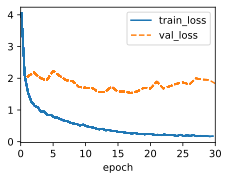

In [ ]:
#Test run everything
data = d2l.MTFraEng(batch_size=128)

num_hiddens, ffn_num_hiddens, num_heads ,num_blocks, dropout = 256, 64, 4, 2, 0.2

encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout)

model = d2l.Seq2Seq(encoder, decoder, tgt_pad = data.tgt_vocab['<pad>'], lr = 0.0015)

trainer = d2l.Trainer(max_epochs = 30, gradient_clip_val = 1, num_gpus = 1)
trainer.fit(model, data)


# Make predictions and evaluate it 
https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#training

This part still confuses me. Read again


In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']

#true Y to compute BLEU
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)

for en, fr, p in zip(engs, fras, preds):
  translation = []
  for token in data.tgt_vocab.to_tokens(p):
    if token == '<eos>':
      break
    translation.append(token)
  
  print(f'{en} => {translation}, bleu= {d2l.bleu(" ".join(translation), fr, k=2)}')

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['va', '!'], bleu= 1.0
i lost . => ["j'ai", 'perdu', '.'], bleu= 1.0
he's calm . => ['<unk>', '.'], bleu= 0.0
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu= 1.0
go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [ ]:
a = [engs[-1]], [fras[-1]]
print(a)
target = data.build([engs[-1]], [fras[-1]])
print(target)

_, dec_attention_weights = model.predict_step(target, d2l.try_gpu(), data.num_steps, True)
# print(len(dec_attention_weights))
# print(len(dec_attention_weights[0]))
# print(len(dec_attention_weights[0][0]))
# print(len(dec_attention_weights[0][0][0]))
# print(len(dec_attention_weights[0][0][0][0]))
# print(len(dec_attention_weights[0][0][0][0][0]))

enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
print('enc attention weights = ', enc_attention_weights.shape)
shape = (num_blocks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)

a = (num_blocks, num_heads, data.num_steps, data.num_steps)
d2l.check_shape(enc_attention_weights,
  (num_blocks, num_heads, data.num_steps, data.num_steps))

(["i'm home ."], ['je suis chez moi .'])
(tensor([[86, 76,  2,  3,  4,  4,  4,  4,  4]]), tensor([[  3, 108, 183,  47, 129,   2,   4,   5,   5]]), tensor([4]), tensor([[108, 183,  47, 129,   2,   4,   5,   5,   5]]))
enc attention weights =  torch.Size([8, 9, 9])


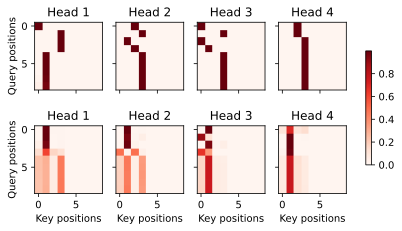

In [ ]:
#encoder attention weights 
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [ ]:
#decoder attention weights
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)

shape = (-1, 2, num_blocks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
          dec_attention_weights.permute(1, 2, 3, 0, 4)

print(dec_attention_weights.shape)

torch.Size([9, 2, 2, 4, 9])


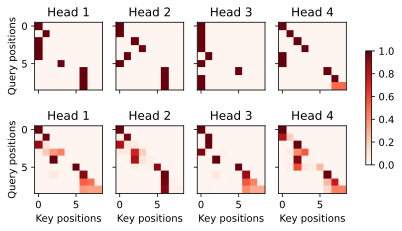

In [ ]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

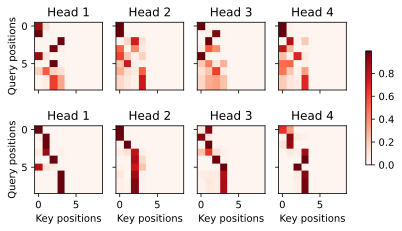

In [ ]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

# Large scale pretraining with Transformers
https://d2l.ai/chapter_attention-mechanisms-and-transformers/large-pretraining-transformers.html

Note: 
- Given larger data for pretraining, the Transformer architecture performs better with an increased model size and training compute - superior scaling behavior

- Primarily, Transformers can be used in three different modes: encoder-only, encoder-decoder, and decoder-only. 

## Encoder only
- vision transformers are encoder only
- inspired by Transformer pre-trained on text: BERT (Bidirectional encoder Representations from Transformer)
- no constraint in encoder so all tokens can attent to each other
- prediction of <mask> depends on input of tokens before and after it in the sequence (that's why BERT is bidirectional)
- without need for manual labeling, large-scale text data from books and Wikipedia can be used for pretraining BERT.

#### Fine-tunning BERT: https://d2l.ai/chapter_attention-mechanisms-and-transformers/large-pretraining-transformers.html#fine-tuning-bert
- pretrained BERT can be fine-tuned
- add additional layers to BERT with randomized parameters
- during fine-tunning, cross-entropy loss between the pred and label on sentiment analysis data is minimized via gradient algorithms, where the additional layer's weights will be updated

BERT used for : text classification, text pair classification, regression, text tagging, question answering

## Encoder-decoder

BART (read the paper)
T5 ( read the paper ) - as of 2022, T5X is recommended
https://github.com/google-research/text-to-text-transfer-transformer#c4

#### T5 is pretrained on C4 (Colossal Clean Crawled Corpus) data
https://github.com/allenai/c4-documentation


#### Fine tune T5

T5 can generate sequences with arbitary length (because of its decoder)
https://d2l.ai/chapter_attention-mechanisms-and-transformers/large-pretraining-transformers.html#fine-tuning-t5

T5 is used for summarization,  classification, image generation, ...

## Decoder only
- decoder-only Transformers have been the de facto architecture in large-scale language modeling

- GPT and GPT2

- Note that the attention pattern in the Transformer decoder enforces that each token can only attend to its past tokens

- a language model can be trained to generate a text sequence conditional on some prefix text sequence

- pretrained language model may generate the task output as a sequence without parameter update, conditional on an input sequence with the task description, task-specific input-output examples, and a prompt (task input)

- zero-shot, one-shot, few-shot

## Scalability

Transformer language model performance improves smoothly as we increase the model size, dataset size, and amount of compute used for training

